"Deskew delle immagini"

Consiste nel ruotare e raddrizzare le immagini in modo da non riscontrare problemi durante la fase successiva di feature extraction.

In [1]:
import cv2 as cv
import numpy as np

def deskew(img):
    # Assicurati che l'immagine sia in scala di grigi
    if len(img.shape) == 3:  # 3 canali, quindi è a colori
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Controlla se l'immagine è in scala di grigi
    if len(img.shape) != 2:
        raise ValueError("L'immagine deve essere in scala di grigi.")
    
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()

    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, 0], [0, 1, 0]])
    rows, cols = img.shape
    deskewed_img = cv.warpAffine(img, M, (cols, rows), flags=cv.WARP_INVERSE_MAP | cv.INTER_LINEAR)
    return deskewed_img

COMMENTO DA QUI ALLA FINE DEL FILE

In [62]:
import os

image_dir = "data/emnist_train_images/1"
image_names = []
descriptor = []

for filename in os.listdir(image_dir):
    if(filename.endswith(".png")):
        image_path = os.path.join(image_dir, filename)
        hog_descriptor = hog_feature_extraction(image_path)
        image_names.append(filename)
        descriptor.append(hog_descriptor)

result_matrix = np.column_stack((image_names, descriptor))

for row in result_matrix:
    print(row[0]+" -> "+ row[1])


ValueError: L'immagine non è in scala di grigi.

In [4]:
def extract_working_region(input_img: np.ndarray, threshold: int = 0) -> np.ndarray:
    """
    Extracts the working region around edge pixels in an image.

    Args:
    - input_img (np.ndarray): Input image as a 3D numpy array (height x width x channels),
                              where channels include RGB and alpha.
    - threshold (int): Threshold distance from edge pixels. If 0, it returns the shape of the fragment.
                        Defaults to 0.

    Returns:
    - working_region (np.ndarray): Interpolation region around edge pixels,
                                         same shape as input_img.

    Raises:
    - ValueError: If input_img does not have an alpha channel or is not a 3D array.

    The function iterates through each pixel in the input image and identifies edge pixels
    based on the alpha channel. It then extracts pixels within a specified distance from the edge
    (defined by the threshold) to form the working region.
    """

    assert len(input_img.shape) == 2

    working_region = np.zeros_like(input_img)

    # Define the neighbor offsets for 4-connectivity
    neighbor_offsets = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
    # Pad the input image with zeros to handle boundary conditions
    padded_img = np.pad(input_img, ((1, 1), (1, 1)), mode='constant')

    for offset_x, offset_y in neighbor_offsets:
        # Shift the image array to obtain the neighbor pixels
        neighbor_x = np.roll(padded_img, offset_x, axis=0)
        neighbor_y = np.roll(padded_img, offset_y, axis=1)

        # Create a mask to identify pixels with alpha zero in the neighbors
        edge_mask = (neighbor_x[1:-1, 1:-1] == 0) | (neighbor_y[1:-1, 1:-1] == 0)

        working_region[edge_mask] = input_img[edge_mask]

        if threshold > 0:
            working_mask = edge_mask.copy()
            # Expand the mask to include pixels within the threshold distance
            for t in range(1, threshold + 1):
                opposite_x = np.roll(edge_mask, -t * offset_x, axis=0)
                opposite_y = np.roll(edge_mask, -t * offset_y, axis=1)

                working_mask = working_mask | (opposite_x | opposite_y)

            working_region[working_mask] = input_img[working_mask]

    return working_region

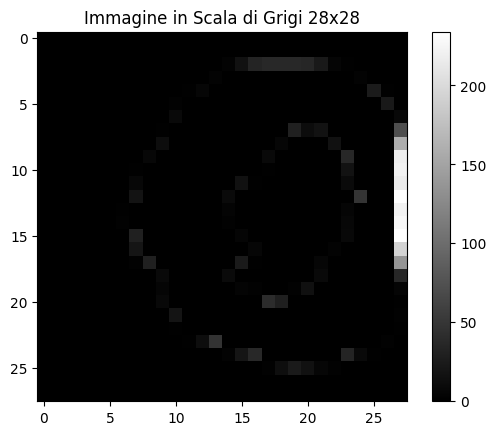

In [9]:
import cv2 as cv
import matplotlib.pyplot as plt

image = cv.imread("data/emnist_test_images/0/0_60.png")
deskewed = deskew(image)

array = extract_working_region(deskewed)

plt.imshow(array, cmap='gray', interpolation='none')
plt.colorbar()
plt.title("Immagine in Scala di Grigi 28x28")
plt.show()

In [13]:
import numpy as np
import cv2 as cv
import os
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report

def load_grayscale_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):
            img = cv.imread(os.path.join(folder, filename), cv.IMREAD_GRAYSCALE)
            if img is not None:
                label = int(filename.split('_')[0])  # assuming the label is in the filename
                images.append(img)
                labels.append(label)
    return images, labels

def extract_working_region(input_img: np.ndarray, threshold: int = 0) -> np.ndarray:
    assert len(input_img.shape) == 2

    working_region = np.zeros_like(input_img)
    neighbor_offsets = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
    padded_img = np.pad(input_img, ((1, 1), (1, 1)), mode='constant')

    for offset_x, offset_y in neighbor_offsets:
        neighbor_x = np.roll(padded_img, offset_x, axis=0)
        neighbor_y = np.roll(padded_img, offset_y, axis=1)
        edge_mask = (neighbor_x[1:-1, 1:-1] == 0) | (neighbor_y[1:-1, 1:-1] == 0)
        working_region[edge_mask] = input_img[edge_mask]

        if threshold > 0:
            working_mask = edge_mask.copy()
            for t in range(1, threshold + 1):
                opposite_x = np.roll(edge_mask, -t * offset_x, axis=0)
                opposite_y = np.roll(edge_mask, -t * offset_y, axis=1)
                working_mask = working_mask | (opposite_x | opposite_y)
            working_region[working_mask] = input_img[working_mask]

    return working_region

def extract_working_region_features(images, threshold=0):
    features = []
    for image in images:
        working_region = extract_working_region(image, threshold)
        features.append(working_region.flatten())
    return np.array(features)

def main():
    folder_path = 'data/emnist_test_images/0'  # Path to the folder containing images
    images, labels = load_grayscale_images_from_folder(folder_path)
    
    # Estrazione delle caratteristiche con la regione di lavoro
    X = extract_working_region_features(images, threshold=0)
    y = np.array(labels)

    print(X)
    print(y)
    

if __name__ == "__main__":
    main()


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Shape of X: (18799, 784)
Shape of y: (18799,)
First 5 labels (y): [39  9 26 44 33 14 11  3 12 16  7  2 16 16 27  6 44 28 45 29]
First 5 pixel values (X):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


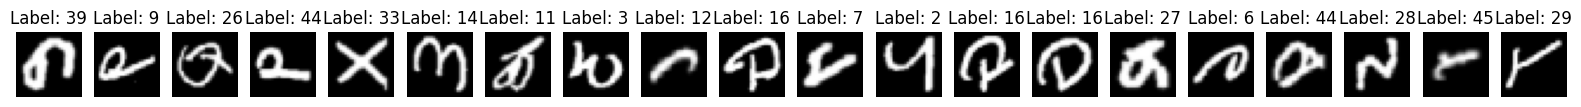

In [19]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def load_and_preprocess_data(csv_path):
    # Carica il dataset dal file CSV
    data = pd.read_csv(csv_path)
    
    # Separazione delle caratteristiche (X) e delle etichette (y)
    X = data.iloc[:, 1:].values  # Tutte le colonne tranne la prima
    y = data.iloc[:, 0].values  # La prima colonna
    
    # Normalizzazione dei valori dei pixel da 0-255 a 0-1
    X = X / 255.0
    
    return X, y

def display_sample_results(X_test, y_test, y_pred, n_samples=5):
    fig, axes = plt.subplots(nrows=1, ncols=n_samples, figsize=(10, 5))
    for i in range(n_samples):
        ax = axes[i]
        ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
        ax.set_title(f"True: {y_test[i]}\nPred: {y_pred[i]}")
        ax.axis('off')
    plt.show()

def main():
    # Percorso al file CSV
    csv_path = '/Users/tonino/Desktop/emnist-balanced-test.csv'
    
    # Carica e preprocessa i dati
    X, y = load_and_preprocess_data(csv_path)
    
     # Stampa le dimensioni di X e y
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape}")
    
    # Stampa i primi 5 valori di X e y per verificare
    print("First 5 labels (y):", y[:20])
    print("First 5 pixel values (X):")
    print(X[:5])
    
    # Visualizza alcune immagini
    n_samples = 20
    fig, axes = plt.subplots(1, n_samples, figsize=(20, 20))
    for i in range(n_samples):
        ax = axes[i]
        ax.imshow(X[i].reshape(28, 28), cmap='gray')
        ax.set_title(f"Label: {y[i]}")
        ax.axis('off')
    plt.show()


if __name__ == "__main__":
    main()


              precision    recall  f1-score   support

           0       0.60      0.69      0.64       400
           1       0.52      0.63      0.57       400
           2       0.74      0.79      0.76       400
           3       0.83      0.90      0.86       400
           4       0.71      0.77      0.74       400
           5       0.72      0.70      0.71       400
           6       0.81      0.89      0.85       400
           7       0.88      0.93      0.90       400
           8       0.72      0.79      0.75       400
           9       0.60      0.78      0.68       400
          10       0.76      0.78      0.77       400
          11       0.78      0.79      0.78       400
          12       0.77      0.82      0.80       400
          13       0.79      0.79      0.79       400
          14       0.80      0.78      0.79       400
          15       0.53      0.50      0.51       400
          16       0.78      0.76      0.77       400
          17       0.77    

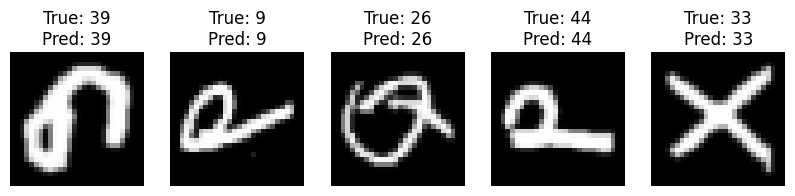

In [24]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def load_and_preprocess_data(csv_path):
    # Carica il dataset dal file CSV
    data = pd.read_csv(csv_path)
    
    # Separazione delle caratteristiche (X) e delle etichette (y)
    X = data.iloc[:, 1:].values  # Tutte le colonne tranne la prima
    y = data.iloc[:, 0].values  # La prima colonna
    
    # Normalizzazione dei valori dei pixel da 0-255 a 0-1
    X = X / 255.0
    
    return X, y

def display_sample_results(X_test, y_test, y_pred, n_samples=5):
    fig, axes = plt.subplots(nrows=1, ncols=n_samples, figsize=(10, 5))
    for i in range(n_samples):
        ax = axes[i]
        ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
        ax.set_title(f"True: {y_test[i]}\nPred: {y_pred[i]}")
        ax.axis('off')
    plt.show()

def main():
    # Percorso al file CSV
    csv_test = '/Users/tonino/Desktop/emnist-balanced-test.csv'
    csv_train = '/Users/tonino/Desktop/emnist-balanced-train.csv'

    # Carica e preprocessa i dati
    X_train, y_train = load_and_preprocess_data(csv_train)
    X_test, y_test = load_and_preprocess_data(csv_test)
    
    
    # Addestramento del modello SVM
    model = svm.SVC(kernel='linear')
    model.fit(X_train, y_train)
    
    # Valutazione del modello
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Visualizza alcuni risultati
    display_sample_results(X_test, y_test, y_pred)

if __name__ == "__main__":
    main()


              precision    recall  f1-score   support

           0       0.65      0.75      0.69       400
           1       0.54      0.73      0.62       400
           2       0.88      0.85      0.86       400
           3       0.96      0.96      0.96       400
           4       0.86      0.89      0.87       400
           5       0.88      0.82      0.85       400
           6       0.89      0.91      0.90       400
           7       0.94      0.96      0.95       400
           8       0.86      0.88      0.87       400
           9       0.62      0.84      0.72       400
          10       0.91      0.92      0.92       400
          11       0.88      0.91      0.90       400
          12       0.91      0.92      0.91       400
          13       0.86      0.87      0.86       400
          14       0.96      0.92      0.94       400
          15       0.68      0.52      0.59       400
          16       0.91      0.86      0.88       400
          17       0.92    

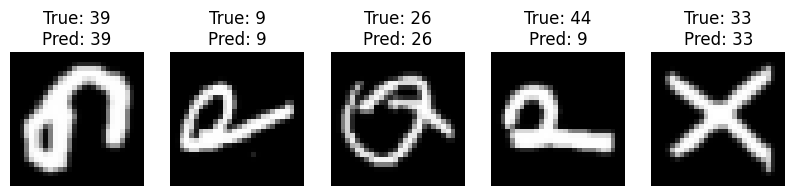

In [2]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def load_and_preprocess_data(csv_path):
    # Carica il dataset dal file CSV
    data = pd.read_csv(csv_path)
    
    # Separazione delle caratteristiche (X) e delle etichette (y)
    X = data.iloc[:, 1:].values  # Tutte le colonne tranne la prima
    y = data.iloc[:, 0].values  # La prima colonna
    
    # Normalizzazione dei valori dei pixel da 0-255 a 0-1
    X = X / 255.0
    
    return X, y

def display_sample_results(X_test, y_test, y_pred, n_samples=5):
    fig, axes = plt.subplots(nrows=1, ncols=n_samples, figsize=(10, 5))
    for i in range(n_samples):
        ax = axes[i]
        ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
        ax.set_title(f"True: {y_test[i]}\nPred: {y_pred[i]}")
        ax.axis('off')
    plt.show()

def main():
    # Percorso al file CSV
    csv_test = '/Users/tonino/Desktop/emnist-balanced-test.csv'
    csv_train = '/Users/tonino/Desktop/emnist-balanced-train.csv'

    # Carica e preprocessa i dati
    X_train, y_train = load_and_preprocess_data(csv_train)
    X_test, y_test = load_and_preprocess_data(csv_test)
    
    
    # Addestramento del modello SVM
    model = svm.SVC(kernel='rbf', gamma='scale')
    model.fit(X_train, y_train)
    
    # Valutazione del modello
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Visualizza alcuni risultati
    display_sample_results(X_test, y_test, y_pred)

if __name__ == "__main__":
    main()
